In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
#from xhistogram.xarray import histogram
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [2]:
uvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel.zarr')
vvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel.zarr')

uvel_merged = uvel_merged.isel(time=slice(41,378)).isel(k=0)

vvel_merged = vvel_merged.isel(time=slice(41,378)).isel(k=0)

uvel_merged['time'] = uvel_merged['time']/ np.timedelta64(1, 's')
vvel_merged['time'] = vvel_merged['time']/ np.timedelta64(1, 's')
grid = Grid(uvel_merged, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [3]:
dt=168
u1 = grid.interp(uvel_merged.U,'X').chunk({'time':-1}).isel(time=slice(168-dt,169+dt))
v1 = grid.interp(vvel_merged.V,'Y',boundary='fill').chunk({'time':-1}).isel(time=slice(168-dt,169+dt))


In [10]:
with ProgressBar():
    uhat2 = xrft.power_spectrum(u1,dim=['time'], window=True, window_correction=True).compute()#, detrend='linear'
    vhat2 = xrft.power_spectrum(v1,dim=['time'], window=True, window_correction=True).compute()#, detrend='linear'
u2plusv2_eul = (uhat2 + vhat2)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  1min 13.5s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  1min 13.2s


In [6]:
z=u1+1j*v1
with ProgressBar():
    z2 = xrft.power_spectrum(z,dim=['time'], window=True, window_correction=True).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  2min  0.4s


In [11]:
spec0 = int((u2plusv2_eul['freq_time'].size-1)/2)

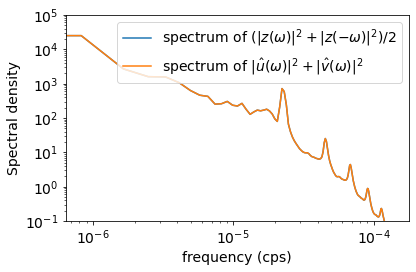

In [19]:
plt.plot(z2.freq_time[spec0:],(z2.mean(['i','j'])[spec0:].values+z2.mean(['i','j'])[spec0::-1].values)/2,label='spectrum of $(|z(\omega)|^2 + |z(-\omega)|^2)$/2')
plt.plot(z2.freq_time[spec0:],u2plusv2_eul.mean(['i','j'])[spec0:].values,label='spectrum of $|\hat{u}(\omega)|^2+|\hat{v}(\omega)|^2$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-1,10**5)
plt.xlabel('frequency (cps)')
plt.ylabel('Spectral density')
plt.tight_layout()

fig=plt.gcf()
fig.savefig('rotary_v_uv.png')